In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os
from collections import OrderedDict
import scipy.io as spio
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir,now)

In [2]:
size = 100
directory = 'dataset3/'+str(size)+'data/'
label_dict = OrderedDict()
input_dict = OrderedDict()
for percentage in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    Labels=[]
    Inputs=[]
    for nu in range(49):
        file = spio.loadmat(directory+str(percentage)+'/'+'rho_'+str(size)+'_'+str(int(percentage*100))+'_'+str(nu+1)+'.mat')
        labels = file['x']
        Labels.append(labels)
        inputs = np.zeros((size,size,2))
        inputs[:int(percentage*100),:,0] = 1
        inputs[:,:,1] = (nu+1)/100
        Inputs.append(inputs)
    label_dict[percentage] = Labels
    input_dict[percentage] = Inputs    

In [3]:
for percentage in [0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]: # It defines the percentage of beam material of total size
    Labels=[]
    Inputs=[]
    for nu in range(49):       # It is the poission ratio from 1 to 49
        file = spio.loadmat(directory+str(percentage)+'/'+'rho,'+str(size)+'_'+str(int(percentage*100))+'_'+str(nu+1)+'.mat')
        labels = file['x']     # in the matlab file 'x' holds images.
        Labels.append(labels)  
        inputs = np.zeros((size,size,2))  
        inputs[:int(percentage*100),:,0] = 1    # input image 1st layer has percentage information given 0:percentage*100,100 = 1
        inputs[:,:,1] = (nu+1)/100    # 2nd layer has nu information, given :,: = nu/100        
        Inputs.append(inputs)
    label_dict[percentage] = Labels
    input_dict[percentage] = Inputs

In [4]:
input_dict[0.8][1][:,:,1]

array([[ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02],
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02],
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02],
       ..., 
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02],
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02],
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02]])

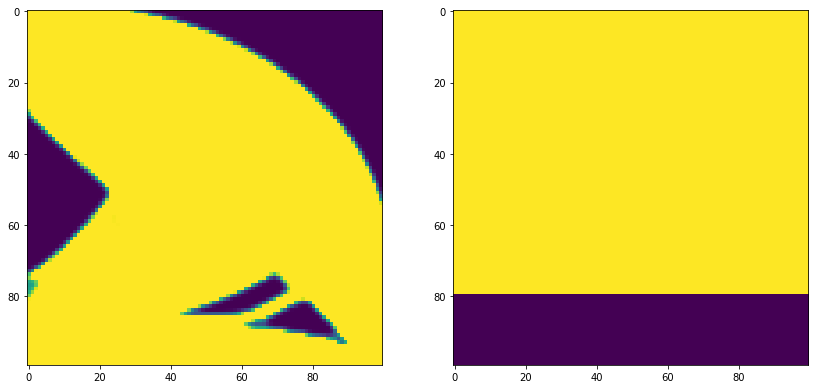

In [5]:
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(label_dict[0.8][48])
plt.subplot(122)
plt.imshow(input_dict[0.8][48][:,:,0])

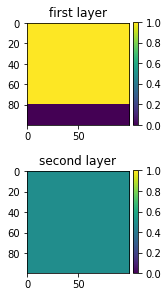

In [6]:
plt.figure(figsize=(2,5))
plt.subplot(211)
plt.imshow(input_dict[0.8][48][:,:,0])
plt.title('first layer')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0,1)
plt.subplot(212)
plt.imshow(input_dict[0.8][48][:,:,1])
plt.title('second layer')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0,1)

In [7]:
def split_data(total_size, training_size, cv_size, testing_size):
    data = np.arange(total_size)
    train = np.random.choice(data, training_size, replace=False)
    Test = np.zeros(total_size-training_size)
    count = 0
    for i in range(total_size):
        if i not in train:
            Test[count] = i
            count = count+1
    cv = np.random.choice(Test, cv_size, replace=False)
    test = np.zeros(testing_size)
    count = 0
    for i in range(len(Test)):
        if Test[i] not in cv:
            test[count] = Test[i]
            count = count +1
    train = np.array(train).astype(np.int)
    cv = np.array(cv).astype(np.int)
    test = np.array(test).astype(np.int)
    return train, cv, test

In [8]:
train_labels = []
train_features = []
cv_labels = []
cv_features = []
test_labels = []
test_features = []
for key in input_dict.keys():
    m = len(label_dict[key])
    m_train = int(m*0.7)
    m_cv = int(m*0.2)
    m_test = int(m-m_train-m_cv)
    train,cv,test = split_data(m,m_train,m_cv,m_test)
    for i in range(m_train):
        train_labels.append(label_dict[key][train[i]])
        train_features.append(input_dict[key][train[i]])
    for i in range(m_cv):
        cv_labels.append(label_dict[key][cv[i]])
        cv_features.append(input_dict[key][cv[i]])
    for i in range(m_test):
        test_labels.append(label_dict[key][test[i]])
        test_features.append(input_dict[key][test[i]])

In [9]:
print('number of train labels = ',len(train_labels))
print('number of cv labels = ', len(cv_labels))
print('number of test labels = ',len(test_labels))

number of train labels =  646
number of cv labels =  171
number of test labels =  114


In [10]:
def conv_layer(inputs, kernel_size_1,kernel_size_2,output_channels,stride,padding='SAME', nonlinearity=None):
    input_channels = int(inputs.get_shape()[3])
    weights = tf.Variable(tf.truncated_normal(shape=[kernel_size_1, kernel_size_2, input_channels, output_channels],
                                              dtype=tf.float32, stddev=0.1))
    biases = tf.Variable(tf.truncated_normal(
        [output_channels], dtype=tf.float32, stddev=0.1))
    conv = tf.nn.conv2d(inputs, weights, strides=[
                        1, stride, stride, 1], padding=padding)
    conv_biased = tf.nn.bias_add(conv, biases)
    if nonlinearity is not None:
        conv_biased = nonlinearity(conv_biased)
    return conv_biased

def transpose_conv_layer(inputs, kernel_size_1,kernel_size_2, num_features, stride_1,stride_2,padding='SAME', nonlinearity=None):
    input_channels = int(inputs.get_shape()[3])
    weights = tf.Variable(tf.truncated_normal(shape=[kernel_size_1, kernel_size_2, num_features, input_channels],
                                              dtype=tf.float32, stddev=0.1))
    biases = tf.Variable(tf.truncated_normal(
        shape=[num_features], dtype=tf.float32, stddev=0.1))
    conv = tf.nn.conv2d_transpose(inputs, weights, [tf.shape(inputs)[0],inputs.get_shape()[1]*stride_1,
                                                    inputs.get_shape()[2]*stride_2,num_features], 
                                  strides=[1, stride_1, stride_2, 1], padding=padding)
    conv_biased = tf.nn.bias_add(conv, biases)
    if nonlinearity is not None:
        conv_biased = nonlinearity(conv_biased)
    conv_biased = tf.reshape(conv_biased, [tf.shape(inputs)[0],inputs.get_shape()[1]*stride_1,
                                            inputs.get_shape()[2]*stride_2,num_features])

    return conv_biased

In [11]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    tf_x = tf.placeholder(shape=[None,100,100,2],dtype=tf.float32)
    tf_y = tf.placeholder(shape=[None,100,100,1],dtype=tf.float32)
    A1 = conv_layer(tf_x,5,5,128,1,padding='SAME',nonlinearity = tf.nn.relu)
    p1 = tf.nn.max_pool(A1,ksize = [1,5,5,1],strides=[1,5,5,1],padding="SAME")
    A2 = conv_layer(p1,5,5,512,1,padding='SAME',nonlinearity = tf.nn.relu)
    p2 = tf.nn.max_pool(A2,ksize = [1,5,5,1],strides = [1,5,5,1],padding='SAME')
    f2 = tf.contrib.layers.flatten(p2)
    A3 = tf.contrib.layers.fully_connected(f2,1024)
    A4 = tf.reshape(A3,[tf.shape(A3)[0],1,1,A3.get_shape()[1]])
    A5 = transpose_conv_layer(A4,5,5,512,5,5,nonlinearity = tf.nn.relu)
    A6 = transpose_conv_layer(A5,2,2,256,2,2,nonlinearity = tf.nn.relu)
    A7 = transpose_conv_layer(A6,5,5,128,5,5,nonlinearity = tf.nn.relu)
    A8 = transpose_conv_layer(A7,2,2,1,2,2,nonlinearity = tf.nn.relu)
    logits = tf.nn.tanh(A8)
    logits = tf.nn.relu(logits)
    loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(logits,tf_y)))
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)
    saver = tf.train.Saver()
    save_path = "/home/http/ME16D412/Sai_and_Harish/weights_sai_and_harish_2/weights_of_Sai_and_Harish_2.ckpt"
    file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

In [12]:
def gen_batch(features, labels, batch_size=1, height=100, width=100, n_channels=1):
    index = np.random.choice(range(len(features)), batch_size)
    feature_batch = []
    target_batch = []
    for i in (index):
        target_batch.append(labels[i])
        feature_batch.append(features[i])
    feature_batch = np.array(feature_batch).astype(
        np.float32).reshape([batch_size, height, width, 2])
    target_batch = np.array(target_batch).astype(
        np.float32).reshape([batch_size, height, width, n_channels])
    return feature_batch, target_batch

0 0.658849
1 0.193765
2 0.112882
3 0.0960544
4 0.0732172
5 0.0695201
6 0.0719815
7 0.06264
8 0.0683113
9 0.0657215
10 0.0684714
11 0.0532164
12 0.0506541
13 0.0532839
14 0.0542659
15 0.0548091
16 0.0541004
17 0.0520006
18 0.0556727
19 0.046457


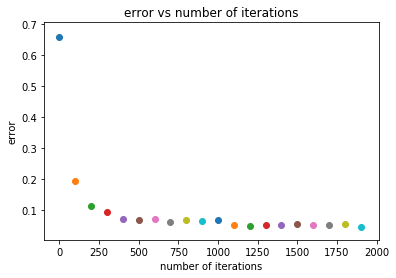

In [13]:
sess = tf.InteractiveSession(graph=graph)
file_writer = tf.summary.FileWriter('logs/graph',sess.graph)
tf.global_variables_initializer().run()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('number of iterations')
ax.set_ylabel('error')
ax.set_title('error vs number of iterations')
count = 0
for i in range(2000):
    a,b = gen_batch(train_features,train_labels,n_channels=1,batch_size=15)
    feed_dict = {
        tf_x:a,
        tf_y:b
    }
    _,l = sess.run([optimizer,loss],feed_dict=feed_dict)
    if i%100 ==0:
        print(count,l)
        count+=1
        ax.scatter(i,l)
saver.save(sess=sess,save_path=save_path)
file_writer.close()

In [14]:
sess = tf.InteractiveSession(graph=graph)
saver.restore(sess=sess,save_path="/home/http/ME16D412/Sai_and_Harish/weights_sai_and_harish/weights_of_Sai_and_Harish_2.ckpt")

INFO:tensorflow:Restoring parameters from /home/http/ME16D412/Sai_and_Harish/weights_sai_and_harish/weights_of_Sai_and_Harish_2.ckpt


In [15]:
a = []
a.append(input_dict[0.45][19])
a.append(input_dict[0.55][19])
a.append(input_dict[0.65][19])
a = np.array(a).astype(np.float32).reshape([len(a),100,100,2])
b = []
b.append(label_dict[0.45][19])
b.append(label_dict[0.55][19])
b.append(label_dict[0.65][19])
b = np.array(b).astype(np.float32).reshape([len(b),100,100,1])

(-0.5, 99.5, 99.5, -0.5)

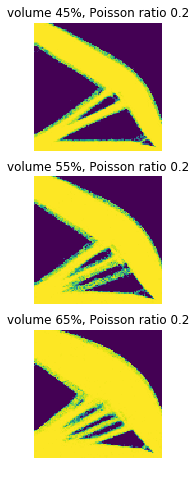

In [16]:
g = sess.run(logits,feed_dict={tf_x:a})
plt.figure(figsize=(4,8))
plt.subplot(311)
plt.title('volume 45%, Poisson ratio 0.2')
plt.imshow(g[0][:,:,0])
plt.axis('off')
plt.subplot(312)
plt.title('volume 55%, Poisson ratio 0.2')
plt.imshow(g[1][:,:,0])
plt.axis('off')
plt.subplot(313)
plt.title('volume 65%, Poisson ratio 0.2')
plt.imshow(g[2][:,:,0])
plt.axis('off')